# Benchmarking unsupervised and supervised models on the 4 site combinatorial library of TrpB
1. Johnston, K. E. et al. A combinatorially complete epistatic fitness landscape in an enzyme active site. Proceedings of the National Academy of Sciences 121, e2400439121 (2024).


The work in this notebook will look fundamentally similar to a subset of the work done by [_Hsu et al._ ](https://www.nature.com/articles/s41587-021-01146-5), but in a single, readable, notebook. Additionally, we consider more than just OHE for AA embeddings. 

We will probe slightly different factors than the original work as an "update" for those conclusions, on a epistatic benchmark. The goal is to do so in a way that highlights the integrated nature of AIDE and showcase how many different model types/methods can be accessed ina  single, readable, notebook with the API in place.

Differences in this work:
- Compare zero shot methods not in original paper to EV mutation: ESM2 and MSA transformer wild type marginal
- Compare different embedding methods as oposed to just one hot encoding: ESM2 mean pooling over whole sequence, ESM2 mean pooling over only the 4 variable residues
- Compare linear to a nonlinear top model
- Conduct 5 fold CV not just for hyperparameter optimization, but also test set performance. Repeat with 20 random instantiations like the original paper.

Naming conventions:

`<zs_model>_<embedding>_<top_model>`

In [1]:
import os
import json

import pandas as pd
import numpy as np
import joblib

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
sns.set_context("talk")

from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, RandomizedSearchCV, cross_validate
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge

from scipy.stats import kendalltau, spearmanr
from scipy.stats import loguniform, uniform

import aide_predict as ap
from aide_predict.utils.msa import MSAProcessing

import logging
logging.basicConfig(level=logging.INFO)

/Users/ekomp/miniconda3/envs/aidep/lib/python3.9/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


## TOC

0. [Acquiring the data](#0-acquiring-the-data)
1. [Data preprocessing](#1-data-preprocessing)
2. [Self supervised predictors](#2-self-supervised-predictors)
3. [Supervised learning](#3-supervised-learning)
4. [Combined models](#4-combined-models)
5. [Compare results](#5-compare-and-visualize-results)

## 0. Acquiring the data
1. Download and extract the data from [here](https://data.caltech.edu/records/h5rah-5z170). You want `data.zip`
2. Extract the data to a directory of your choice
3. Assign the global variable `RAW_DATA_DIR` to the extracted directory

In [2]:
RAW_DATA_DIR = os.path.join('.', 'data', 'epistatic', 'data')

### 0.1. Retrieve the assay labeled data

In [3]:
df = pd.read_csv(os.path.join(RAW_DATA_DIR, 'figure_data', '4-site_merged_replicates', '20230827', 'four-site_summary_AA_data.csv'))

In [4]:
df = df[['AAs', 'avg_mu-bg/max']].rename(columns={'AAs': 'sequence', 'avg_mu-bg/max': 'fitness'})

In [5]:
# remove star aas
df = df[~df['sequence'].apply(lambda x: '*' in x)]

### 0.2. Define wildtype sequence, get full sequences of variants

The wildtype in the study is not acutally the wildtype protein, they started with a variant. Define the true wt, apply mutations.

In [6]:
wt = ap.ProteinSequence(
    'MKGYFGPYGGQYVPEILMGALEELEAAYEGIMKDESFWKEFNDLLRDYAGRPTPLYFARRLSEKYGARVYLKREDLLHTGAHKINNAIGQVLLAKLMGKTRIIAETGAGQHGVATATAAALFGMECVIYMGEEDTIRQKLNVERMKLLGAKVVPVKSGSRTLKDAIDEALRDWITNLQTTYYVFGSVVGPHPYPIIVRNFQKVIGEETKKQIPEKEGRLPDYIVACVSGGSNAAGIFYPFIDSGVKLIGVEAGGEGLETGKHAASLLKGKIGYLHGSKTFVLQDDWGQVQVSHSVSAGLDYSGVGPEHAYWRETGKVLYDAVTDEEALDAFIELSRLEGIIPALESSHALAYLKKINIKGKVVVVNLSGRGDKDLESVLNHPYVRERIRLEHHHHHH',
    id='wt',
)

In [7]:
mutations = ['P18G', 'E29G', 'I68V', 'K95L', 'P139L', 'N166D', 'I183F', 'L212P', 'G227S', 'T291S']
wt = wt.mutate(mutations, one_indexed=False)
wt.id='Tm8D9'

In [8]:
msa = ap.ProteinSequences.from_fasta(os.path.join(RAW_DATA_DIR, 'EVMutation', 'TARGET_b0.1', 'align', 'TARGET_b0.1.a2m'))

In [9]:
wt.id = msa[0].id

In [62]:
msa_prc = MSAProcessing()
msa_sub = msa_prc.process(msa, focus_seq_id=wt.id)

INFO:aide_predict.utils.msa:Starting MSA processing with 138861 sequences
INFO:aide_predict.utils.msa:Preprocessing MSA
INFO:aide_predict.utils.msa:Preprocessed MSA: 137434 sequences, 397 columns
INFO:aide_predict.utils.msa:Computing sequence weights
INFO:aide_predict.bespoke_models.base:Created metadata folder: /var/folders/4b/6yg7r65x0152cnhzpgzdhmvrjcvswz/T/20241014_153609
INFO:aide_predict.bespoke_models.base:Fitting OneHotAlignedEmbedding
INFO:aide_predict.bespoke_models.base:Transforming input using OneHotAlignedEmbedding
/Users/ekomp/Documents/repos/lab/aide_predict/aide_predict/bespoke_models/embedders/ohe.py:278: UserWarning: Input sequences are already aligned. Using them as-is for encoding.
  warnings.warn("Input sequences are already aligned. Using them as-is for encoding.")
INFO:aide_predict.utils.msa:Computed weights: Neff (effective sequence count) = 57762.59
INFO:aide_predict.utils.msa:MSA processing completed


In [64]:
selected_indices = np.random.choice(len(msa_sub), replace=False, size=1000, p=msa_sub.weights/sum(msa_sub.weights))

In [66]:
selected_indices = [0] + list(selected_indices)

In [68]:
msa_sub = msa_sub[np.array(selected_indices)]
msa_sub.to_fasta('selected_msa.fasta')

In [8]:
msa_sub = ap.ProteinSequences.from_fasta('selected_msa.fasta')
wt = msa_sub[0]

In [9]:
library_positions = [182, 183, 226, 227]
mutation_strings_base = [
    f"{wt[pos]}{pos}" for pos in library_positions
]
def get_full_sequence(wt, aas):
    mutation_strings = [mutation_strings_base[i]+aa for i, aa in enumerate(aas)]
    return wt.mutate(mutation_strings, one_indexed=False)
df['full_sequence'] = df['sequence'].apply(lambda x: get_full_sequence(wt, x))

Shuffle the data and create X, y

In [10]:
df = df.sample(frac=1, random_state=0)
X = ap.ProteinSequences(df['full_sequence'].tolist())
y = df['fitness'].values

Plot the activity data

In [11]:
wt_activity = df[df['sequence'] == 'VFVS'].iloc[0]['fitness']
wt_activity

0.4080739252340478

Text(0.5, 0, 'Fitness')

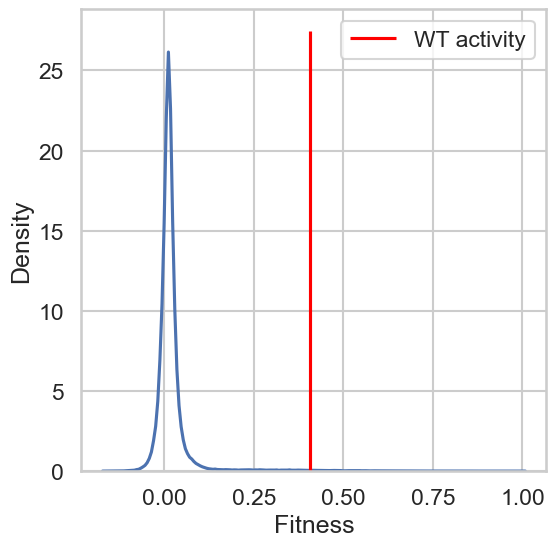

In [12]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.kdeplot(y, ax=ax, bw_adjust=0.5)
ax.vlines(wt_activity, 0, ax.get_ylim()[1], color='red', label='WT activity')
ax.legend()
ax.set_xlabel('Fitness')

## 1. Data preprocessing

We need to:
1. Define splits for Kfold the better resemble actual training set sizes, eg. train on 130k variants, test on remaining 20k is not reasonable. Note that plenty of work on active learning suggest we can get accuracy with fewer samples by non random selection, but acquisition functions/active learning are currently native to AIDE. It is not hard to use AIDE models in an active learning loop, but we do not have boilerplate importable code for that yet so here we are doing more standard supervised model evaluation.
2. Define metrics that are relevant to the study, kendall's tau and top 10 recovery is a better representation of our experimental goal than spearman.
3. Define a wrapper function to run hyperparameter optimization and test set as training size increases, over random instatiation

### 1.1. Define splits

In [13]:
def modified_kfold_iterator(X, n_splits=5, shuffle=True, random_state=42, training_size=96*100, test_size='all'):
    """KFold iterator that uses smaller training set and larger test set
    
    Params:
    -------
    X: array-like
        The data to split
    n_splits: int
        Number of splits
    shuffle: bool
        Whether to shuffle the data
    random_state: int
        Random state
    training_size: int
        Size of the training set, will be sampled from fold
    test_size: int or 'all'
        Size of the test set, if 'all' then all data not in training set will be used
    """
    kf = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
    np.random.seed(random_state)
    for test_index, train_index in kf.split(X):
        # sample to training size
        train_index = np.random.choice(train_index, training_size, replace=False)
        if test_size != 'all':
            test_index = np.random.choice(test_index, test_size, replace=False)
        yield train_index, test_index

### 1.2. Define metrics

In [14]:
def top10_in_plate(y_true, y_pred):
    """Calculate top 10 recovery in a single plate, eg. how many of the top 10 true values are in the top 96 predicted values"""
    # now get top 10 recovery in a single plate
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    top_10_idx = list(np.argsort(y_true)[-10:])
    top_100_predicted_idx = list(np.argsort(y_pred)[-96:])
    top_10_recovery = sum([1 for idx in top_10_idx if idx in top_100_predicted_idx]) / 10
    return top_10_recovery

In [15]:
scoring = {
    'kendall_tau': make_scorer(lambda y_true, y_pred: kendalltau(y_true, y_pred)[0]),
    'top10_in_plate': make_scorer(top10_in_plate),
    'spearman': make_scorer(lambda y_true, y_pred: spearmanr(y_true, y_pred)[0]),
}

In [30]:
def cv_1(model, X, y, training_size=96*10, random_state=42):
    """Cross validate a model with a single training size.
    """
    return cross_validate(
        model,
        X,
        y,
        cv=modified_kfold_iterator(X, training_size=training_size, random_state=random_state),
        scoring=scoring,
    )

def cv_increasing_data_size(model, X, y, training_sizes=[24*2, 24*3, 24*4, 24*5, 24*6, 24*7, 24*8, 24*9, 24*10, 24*12, 24*16, 24*20, 24*24, 24*100], n_repeats=20):
    """Cross validate a model with increasing training sizes, over a number of repeats."""
    results = []
    for repeat in range(n_repeats):
        for training_size in training_sizes:
            results.append(cv_1(model, X, y, training_size=training_size, random_state=repeat))
            results[-1]['training_size'] = training_size
    return results  

def hyperopt_and_scoring(model, X, y, param_distributions, ho_training_size=96*10, eval_training_sizes=[24*2, 24*3, 24*4, 24*5, 24*6, 24*7, 24*8, 24*9, 24*10, 24*12, 24*16, 24*20, 24*24, 24*100], n_repeats=20):
    """Hyperparameter optimization and scoring over increasing training sizes in one call.
    
    Params
    ------
    model: sklearn estimator
        The model to optimize and score
    X: array-like
    y: array-like
    param_distributions: dict
        The hyperparameter distributions to search over, to be fed to RandomizedSearchCV
    ho_training_size: int
        The size of the training set for hyperparameter optimization
    eval_training_sizes: list of ints
        The training sizes to evaluate the model on
    n_repeats: int
        Number of repeats to average over
    """
    searcher = RandomizedSearchCV(
        model,
        param_distributions=param_distributions,
        n_iter=100,
        n_jobs=1,
        cv=modified_kfold_iterator(X, training_size=ho_training_size),
        scoring=scoring,
        refit='kendall_tau',
    )
    searcher.fit(X, y)
    best_params = searcher.best_params_
    scores = cv_increasing_data_size(model.set_params(**best_params), X, y, training_sizes=eval_training_sizes, n_repeats=n_repeats)
    return scores

## 2. Self supervised predictors

### 2.1 ESM2 with wildtype marginal

In [17]:
esm2liklihood = ap.ESM2LikelihoodWrapper(
    wt=wt,
    marginal_method='wildtype_marginal',
    device='mps',
    metadata_folder=os.path.join('.', 'data', 'epistatic', 'esm2likelihood'),
    model_checkpoint='esm2_t33_650M_UR50D',
    use_cache=True,
)
esm2liklihood.fit([])

INFO:aide_predict.bespoke_models.base:Fitting ESM2LikelihoodWrapper


ESM2LikelihoodWrapper(device='mps', marginal_method='wildtype_marginal',
                      metadata_folder='./data/epistatic/esm2likelihood',
                      model_checkpoint='esm2_t33_650M_UR50D',
                      wt=ProteinSequence(id='TARGET/1-397', seq='mkgyfgpyggqyvpeilmga...'))

In [18]:
esm_none_none_scores = cv_1(esm2liklihood, X, y)

INFO:aide_predict.bespoke_models.base:Found 0 cached results, running on 127303 uncached sequences.
INFO:aide_predict.bespoke_models.base:Transforming input using ESM2LikelihoodWrapper
/Users/ekomp/miniconda3/envs/aidep/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Computing log likelihoods: 100%|██████████| 1/1 [00:00<00:00,  1.41sequence/s]
INFO:aide_predict.bespoke_models.base:Found 95477 cached results, running on 31826 uncached sequences.
INFO:aide_predict.bespoke_models.base:Transforming input using ESM2LikelihoodWrapper
Computing log likelihoods: 100%|██████████| 1/1 [00:00<00:00,  6.62sequence/s]
INFO:aide_predict.bespoke_models.base:Found 127303 cached results, running on 0 uncached sequences.
INFO:aide_predict.bespoke_models.base:Found 127303 cached resu

In [51]:
joblib.dump(esm_none_none_scores, 'esm_none_none_scores.joblib')

['esm_none_none_scores.joblib']

### 2.2 EVC

In [20]:
evc = ap.EVMutationWrapper(
    wt=wt,
    metadata_folder=os.path.join('.', 'data', 'epistatic', 'evmutation'),
)
evc.fit(msa_sub)

INFO:aide_predict.bespoke_models.base:Fitting EVMutationWrapper


EVMutationWrapper(metadata_folder='./data/epistatic/evmutation',
                  wt=ProteinSequence(id='TARGET/1-397', seq='mkgyfgpyggqyvpeilmga...'))

In [21]:
evc_none_none_scores = cv_1(evc, X, y)

INFO:aide_predict.bespoke_models.base:Transforming input using EVMutationWrapper
  0%|          | 0/127303 [00:00<?, ?it/s]/Users/ekomp/Documents/repos/lab/aide_predict/aide_predict/bespoke_models/predictors/evmutation.py:183: UserWarning: Mutation M1m is not supported by EVCouplings statistics and will be ignored for scoring.
  warnings.warn(f"Mutation {subs_from}{subs_pos}{subs_to} is not supported by EVCouplings statistics and will be ignored for scoring.")
/Users/ekomp/Documents/repos/lab/aide_predict/aide_predict/bespoke_models/predictors/evmutation.py:183: UserWarning: Mutation K2k is not supported by EVCouplings statistics and will be ignored for scoring.
  warnings.warn(f"Mutation {subs_from}{subs_pos}{subs_to} is not supported by EVCouplings statistics and will be ignored for scoring.")
/Users/ekomp/Documents/repos/lab/aide_predict/aide_predict/bespoke_models/predictors/evmutation.py:183: UserWarning: Mutation G3g is not supported by EVCouplings statistics and will be ignored 

In [52]:
joblib.dump(evc_none_none_scores, 'evc_none_none_scores.joblib')

['evc_none_none_scores.joblib']

### 2.3 MSATransformer

In [23]:
msa_likelihood = ap.MSATransformerLikelihoodWrapper(
    wt=wt,
    metadata_folder=os.path.join('.', 'data', 'epistatic', 'msalikelihood'),
    device='mps',
    marginal_method='wildtype_marginal',
)
msa_likelihood.fit(msa_sub)

INFO:aide_predict.bespoke_models.base:Fitting MSATransformerLikelihoodWrapper


MSATransformerLikelihoodWrapper(device='mps',
                                marginal_method='wildtype_marginal',
                                metadata_folder='./data/epistatic/msalikelihood',
                                use_cache=True,
                                wt=ProteinSequence(id='TARGET/1-397', seq='mkgyfgpyggqyvpeilmga...'))

In [24]:
msa_none_none_scores = cv_1(msa_likelihood, X, y)

Error reading HDF5 file: [Errno 2] Unable to open file (unable to open file: name = '/Users/ekomp/Documents/repos/lab/aide_predict/showcase/data/epistatic/msalikelihood/cache/embeddings.h5', errno = 2, error message = 'No such file or directory', flags = 40, o_flags = 0)


INFO:aide_predict.bespoke_models.base:Found 0 cached results, running on 127303 uncached sequences.
INFO:aide_predict.bespoke_models.base:Transforming input using MSATransformerLikelihoodWrapper
MSA batches: 100%|██████████| 11/11 [00:33<00:00,  3.02s/it]
MSA batches: 12it [00:36,  3.02s/it]                        
Computing log likelihoods: 100%|██████████| 1/1 [00:36<00:00, 36.20s/sequence]
INFO:aide_predict.bespoke_models.base:Found 95477 cached results, running on 31826 uncached sequences.
INFO:aide_predict.bespoke_models.base:Transforming input using MSATransformerLikelihoodWrapper
MSA batches: 100%|██████████| 11/11 [00:33<00:00,  3.02s/it]
MSA batches: 12it [00:35,  2.98s/it]                        
Computing log likelihoods: 100%|██████████| 1/1 [00:35<00:00, 35.82s/sequence]
INFO:aide_predict.bespoke_models.base:Found 127303 cached results, running on 0 uncached sequences.
INFO:aide_predict.bespoke_models.base:Found 127303 cached results, running on 0 uncached sequences.
INFO:

In [25]:
joblib.dump(msa_none_none_scores, 'msa_none_none_scores.joblib')

['msa_none_none_scores.joblib']

## 3. Supervised learning

### 3.0 downstream pipelines

We can specifiy embedders with AIDE into a scikitlearn pipeline, but to avoid recomputation of embeddings we will precompute them and pass them into specified pipelines.

In [26]:
linear_nopca = Pipeline([
    ('scaler', StandardScaler()),
    ('model', TransformedTargetRegressor(
        regressor=Ridge(
            alpha=1.0,
        )))])
linear_pca = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.9)),
    ('model', TransformedTargetRegressor(
        regressor=Ridge(
            alpha=1.0,
        )))])
linear_param_space = {
    'model__regressor__alpha': loguniform(1e-3, 1e3),
}

In [27]:
mlp_nopca = Pipeline([
    ('scaler', StandardScaler()),
    ('model', TransformedTargetRegressor(
        regressor=MLPRegressor(
            hidden_layer_sizes=(20, 20),
            max_iter=1000,
            early_stopping=True
        )))])
mlp_pca = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.9)),
    ('model', TransformedTargetRegressor(
        regressor=MLPRegressor(
            hidden_layer_sizes=(20, 20),
            max_iter=1000,
            early_stopping=True
        )))])
mlp_param_space = {
    'model__regressor__hidden_layer_sizes': [(20,), (20, 20), (20, 20, 20), (20, 20, 20, 20)],
    'model__regressor__alpha': loguniform(1e-6, 1e-1),
    'model__regressor__activation': ['relu', 'tanh'],
}

### 3.1 OHE linear

In [28]:
ohe = ap.OneHotProteinEmbedding(
    positions=library_positions,
    metadata_folder=os.path.join('.', 'data', 'epistatic', 'onehot'))
X_ohe = ohe.fit_transform(X)

INFO:aide_predict.bespoke_models.base:Fitting OneHotProteinEmbedding
INFO:aide_predict.bespoke_models.base:Transforming input using OneHotProteinEmbedding


In [31]:
none_ohe_linear_scores = hyperopt_and_scoring(linear_nopca, X_ohe, y, linear_param_space)
joblib.dump(none_ohe_linear_scores, 'none_ohe_linear_scores.joblib')

['none_ohe_linear_scores.joblib']

### 3.2 OHE MLP

In [33]:
none_ohe_mlp_scores = hyperopt_and_scoring(mlp_nopca, X_ohe, y, mlp_param_space)
joblib.dump(none_ohe_mlp_scores, 'none_ohe_mlp_scores.joblib')

/Users/ekomp/miniconda3/envs/aidep/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ekomp/miniconda3/envs/aidep/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ekomp/miniconda3/envs/aidep/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ekomp/miniconda3/envs/aidep/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  war

['none_ohe_mlp_scores.joblib']

### 3.3 ESM2 embeddings, full sequence, linear model

Include scaling and PCA to reduce dims.

In [34]:
esm2_embedder = ap.ESM2Embedding(
    pool='mean',
    metadata_folder=os.path.join('.', 'data', 'epistatic', 'esm2emb_full'),
    device='mps',
    model_checkpoint='esm2_t12_35M_UR50D',
    use_cache=True,
    batch_size=180
)
esm2_embedder.fit([])
X_esm = esm2_embedder.transform(X)

/Users/ekomp/miniconda3/envs/aidep/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:aide_predict.bespoke_models.base:Fitting ESM2Embedding
INFO:aide_predict.bespoke_models.base:Found 159129 cached results, running on 0 uncached sequences.


In [35]:
none_esmfull_linear_scores = hyperopt_and_scoring(linear_pca, X_esm, y, linear_param_space)
joblib.dump(none_esmfull_linear_scores, 'none_esmfull_linear_scores.joblib')

['none_esmfull_linear_scores.joblib']

### 3.4 ESM2 embeddings, full sequence, MLP

In [36]:
none_esmfull_mlp_scores = hyperopt_and_scoring(mlp_pca, X_esm, y, mlp_param_space)
joblib.dump(none_esmfull_mlp_scores, 'none_esmfull_mlp_scores.joblib')

/Users/ekomp/miniconda3/envs/aidep/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ekomp/miniconda3/envs/aidep/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ekomp/miniconda3/envs/aidep/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ekomp/miniconda3/envs/aidep/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  war

['none_esmfull_mlp_scores.joblib']

### 3.5 ESM2 embeddings, only changing residues, linear

In [37]:
esm2_embedder_only4 = ap.ESM2Embedding(
    pool='mean',
    metadata_folder=os.path.join('.', 'data', 'epistatic', 'esm2emb_design_space'),
    device='mps',
    model_checkpoint='esm2_t12_35M_UR50D',
    use_cache=True,
    batch_size=180,
    positions=library_positions
)
esm2_embedder_only4.fit([])
X_esm_only4 = esm2_embedder_only4.transform(X)

/Users/ekomp/miniconda3/envs/aidep/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:aide_predict.bespoke_models.base:Fitting ESM2Embedding
INFO:aide_predict.bespoke_models.base:Found 159129 cached results, running on 0 uncached sequences.


In [38]:
none_esm4sites_linear_scores = hyperopt_and_scoring(linear_pca, X_esm_only4, y, linear_param_space)
joblib.dump(none_esm4sites_linear_scores, 'none_esm4sites_linear_scores.joblib')

['none_esm4sites_linear_scores.joblib']

### 3.6 ESM2 embeddings, only changing residues, MLP

In [39]:
none_esm4sites_mlp_scores = hyperopt_and_scoring(mlp_pca, X_esm_only4, y, mlp_param_space)
joblib.dump(none_esm4sites_mlp_scores, 'none_esm4sites_mlp_scores.joblib')

/Users/ekomp/miniconda3/envs/aidep/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ekomp/miniconda3/envs/aidep/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ekomp/miniconda3/envs/aidep/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ekomp/miniconda3/envs/aidep/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  war

['none_esm4sites_mlp_scores.joblib']

## 4. Combined models

### 4.1 EVC plus one hot linear

In [40]:
X_evc = evc.transform(X)

INFO:aide_predict.bespoke_models.base:Transforming input using EVMutationWrapper
  0%|          | 0/159129 [00:00<?, ?it/s]/Users/ekomp/Documents/repos/lab/aide_predict/aide_predict/bespoke_models/predictors/evmutation.py:183: UserWarning: Mutation M1m is not supported by EVCouplings statistics and will be ignored for scoring.
  warnings.warn(f"Mutation {subs_from}{subs_pos}{subs_to} is not supported by EVCouplings statistics and will be ignored for scoring.")
/Users/ekomp/Documents/repos/lab/aide_predict/aide_predict/bespoke_models/predictors/evmutation.py:183: UserWarning: Mutation K2k is not supported by EVCouplings statistics and will be ignored for scoring.
  warnings.warn(f"Mutation {subs_from}{subs_pos}{subs_to} is not supported by EVCouplings statistics and will be ignored for scoring.")
/Users/ekomp/Documents/repos/lab/aide_predict/aide_predict/bespoke_models/predictors/evmutation.py:183: UserWarning: Mutation G3g is not supported by EVCouplings statistics and will be ignored 

In [56]:
X_ = np.concatenate([X_ohe, X_evc], axis=1)

In [42]:
evc_ohe_linear_scores = hyperopt_and_scoring(linear_nopca, X_, y, linear_param_space)
joblib.dump(evc_ohe_linear_scores, 'evc_ohe_linear_scores.joblib')

['evc_ohe_linear_scores.joblib']

### 4.2 EVC plus one hot MLP

In [57]:
evc_ohe_mlp_scores = hyperopt_and_scoring(mlp_nopca, X_, y, mlp_param_space)
joblib.dump(evc_ohe_mlp_scores, 'evc_ohe_mlp_scores.joblib')

/Users/ekomp/miniconda3/envs/aidep/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ekomp/miniconda3/envs/aidep/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ekomp/miniconda3/envs/aidep/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ekomp/miniconda3/envs/aidep/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  war

['evc_ohe_mlp_scores.joblib']

### 4.3 EVC plus ESM2 linear

In [54]:
X_ = np.concatenate([X_esm, X_evc], axis=1)

In [45]:
evc_esmfull_linear_scores = hyperopt_and_scoring(linear_pca, X_, y, linear_param_space)
joblib.dump(evc_esmfull_linear_scores, 'evc_esmfull_linear_scores.joblib')

['evc_esmfull_linear_scores.joblib']

### 4.4 EVC plus ESM2 MLP

In [55]:
evc_esmfull_mlp_scores = hyperopt_and_scoring(mlp_pca, X_, y, mlp_param_space)
joblib.dump(evc_esmfull_mlp_scores, 'evc_esmfull_mlp_scores.joblib')

/Users/ekomp/miniconda3/envs/aidep/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ekomp/miniconda3/envs/aidep/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ekomp/miniconda3/envs/aidep/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ekomp/miniconda3/envs/aidep/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  war

['evc_esmfull_mlp_scores.joblib']

### 4.5 EVC plus ESM2 only 4 linear

In [47]:
X_ = np.concatenate([X_esm_only4, X_evc], axis=1)

In [48]:
evc_esm4sites_linear_scores = hyperopt_and_scoring(linear_pca, X_, y, linear_param_space)
joblib.dump(evc_esm4sites_linear_scores, 'evc_esm4sites_linear_scores.joblib')

['evc_esm4sites_linear_scores.joblib']

### 4.6 EVC plus ESM2 only 4 MLP

In [49]:
evc_esm4sites_mlp_scores = hyperopt_and_scoring(mlp_pca, X_, y, mlp_param_space)
joblib.dump(evc_esm4sites_mlp_scores, 'evc_esm4sites_mlp_scores.joblib')

/Users/ekomp/miniconda3/envs/aidep/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ekomp/miniconda3/envs/aidep/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ekomp/miniconda3/envs/aidep/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ekomp/miniconda3/envs/aidep/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  war

['evc_esm4sites_mlp_scores.joblib']

## 5. Compare and visualize results

In [58]:
zs_scores = {
    'evc_none_none': joblib.load('evc_none_none_scores.joblib'),
    'esm_none_none': joblib.load('esm_none_none_scores.joblib'),
    'msa_none_none': joblib.load('msa_none_none_scores.joblib'),
}
supervised_scores = {
    'none_ohe_linear': joblib.load('none_ohe_linear_scores.joblib'),
    'none_ohe_mlp': joblib.load('none_ohe_mlp_scores.joblib'),
    'none_esmfull_linear': joblib.load('none_esmfull_linear_scores.joblib'),
    'none_esmfull_mlp': joblib.load('none_esmfull_mlp_scores.joblib'),
    'none_esm4sites_linear': joblib.load('none_esm4sites_linear_scores.joblib'),
    'none_esm4sites_mlp': joblib.load('none_esm4sites_mlp_scores.joblib'),
    'evc_ohe_linear': joblib.load('evc_ohe_linear_scores.joblib'),
    'evc_ohe_mlp': joblib.load('evc_ohe_mlp_scores.joblib'),
    'evc_esmfull_linear': joblib.load('evc_esmfull_linear_scores.joblib'),
    'evc_esmfull_mlp': joblib.load('evc_esmfull_mlp_scores.joblib'),
    'evc_esm4sites_linear': joblib.load('evc_esm4sites_linear_scores.joblib'),
    'evc_esm4sites_mlp': joblib.load('evc_esm4sites_mlp_scores.joblib'),
}

In [59]:
data = []
for model, score_list in supervised_scores.items():
    for score_dict in score_list:
        training_size = score_dict['training_size']
        for metric in ['kendall_tau', 'spearman', 'top10_in_plate']:
            for point in score_dict[f'test_{metric}']:
                data.append({
                    'Model': model,
                    'Metric': metric,
                    'Score': point,
                    'Training Size': training_size
                })

supervised_df = pd.DataFrame(data)
supervised_df[['zs', 'embedding', 'topmodel']] = supervised_df['Model'].str.split('_', expand=True)
data = []
for model, scores in zs_scores.items():
    for metric in ['kendall_tau', 'spearman', 'top10_in_plate']:
        for point in scores[f'test_{metric}']:
            data.append({
                'Model': model,
                'Metric': metric,
                'Score': point,
                'Training Size': 0.0
            })
zs_df = pd.DataFrame(data)
zs_df[['zs', 'embedding', 'topmodel']] = zs_df['Model'].str.split('_', expand=True)

In [60]:
# determined by embedding type
color_map = {
    'none': 'grey',
    'ohe': 'tab:blue',
    'esmfull': 'tab:orange',
    'esm4sites': 'tab:green',
}
# determined by ZS method
linestyle_map = {
    'none': ':',
    'evc': '-',
    'esm': '--',
    'msa': '-.',
}
# determined by top model
marker_map = {
    'none': 'o',
    'linear': 's',
    'mlp': 'd',
}
    

/var/folders/4b/6yg7r65x0152cnhzpgzdhmvrjcvswz/T/ipykernel_42112/2180773612.py:25: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean = df_.mean()['Score']


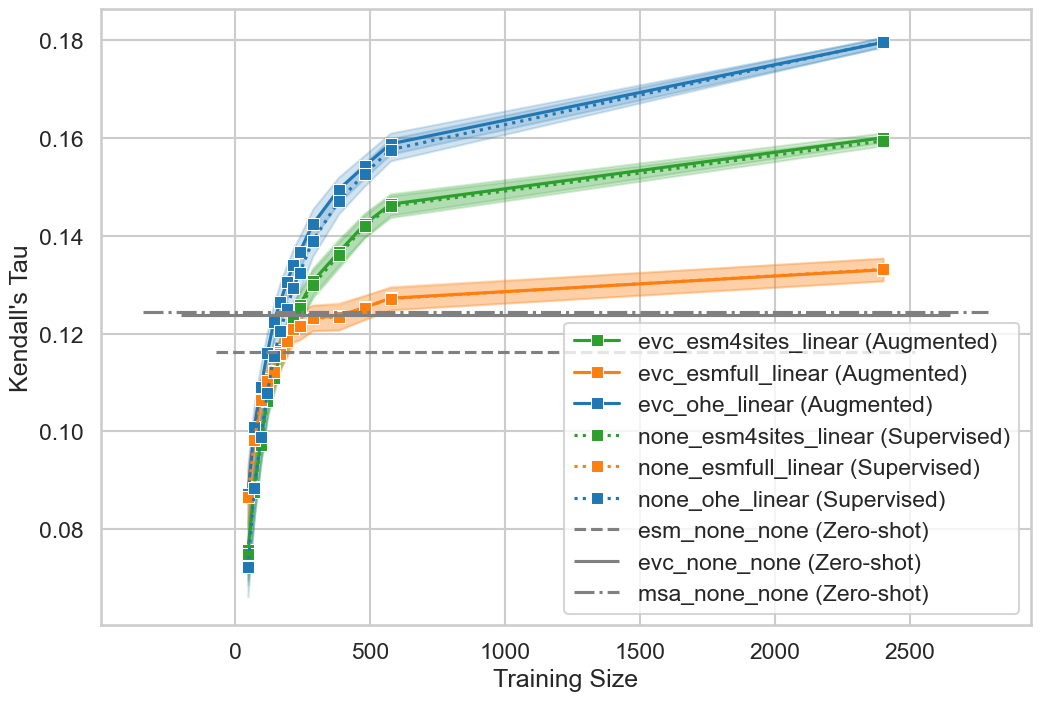

In [69]:
# create plot of ZS vs supervised vs augmented linear, like original paper
metric = 'kendall_tau'

fig, ax = plt.subplots(figsize=(12, 8))

for model, df in supervised_df.groupby('Model'):
    df_ = df[df['Metric'] == metric]
    color, linestyle, marker = color_map[model.split('_')[1]], linestyle_map[model.split('_')[0]], marker_map[model.split('_')[2]]
    if model.split('_')[2] =='mlp':
        continue
    label = model
    if model.split('_')[0] == 'none':
        label += ' (Supervised)'
    else:
        label += ' (Augmented)'
    sns.lineplot(x='Training Size', y='Score', data=df_, ax=ax,
                    label=label, color=color, linestyle=linestyle, marker=marker)

for model, df in zs_df.groupby('Model'):
    df_ = df[df['Metric'] == metric]
    color, linestyle, marker = color_map[model.split('_')[1]], linestyle_map[model.split('_')[0]], marker_map[model.split('_')[2]]
    label = model + ' (Zero-shot)'
    xmin = ax.get_xlim()[0]
    xmax = ax.get_xlim()[1]
    mean = df_.mean()['Score']
    ax.hlines(mean, xmin, xmax, color=color, linestyle=linestyle, label=label)

ax.set_xlabel('Training Size')
ax.set_ylabel("Kendall's Tau")
plt.legend()
plt.savefig('zs_vs_supervised_vs_augmented.png', bbox_inches='tight', dpi=300)


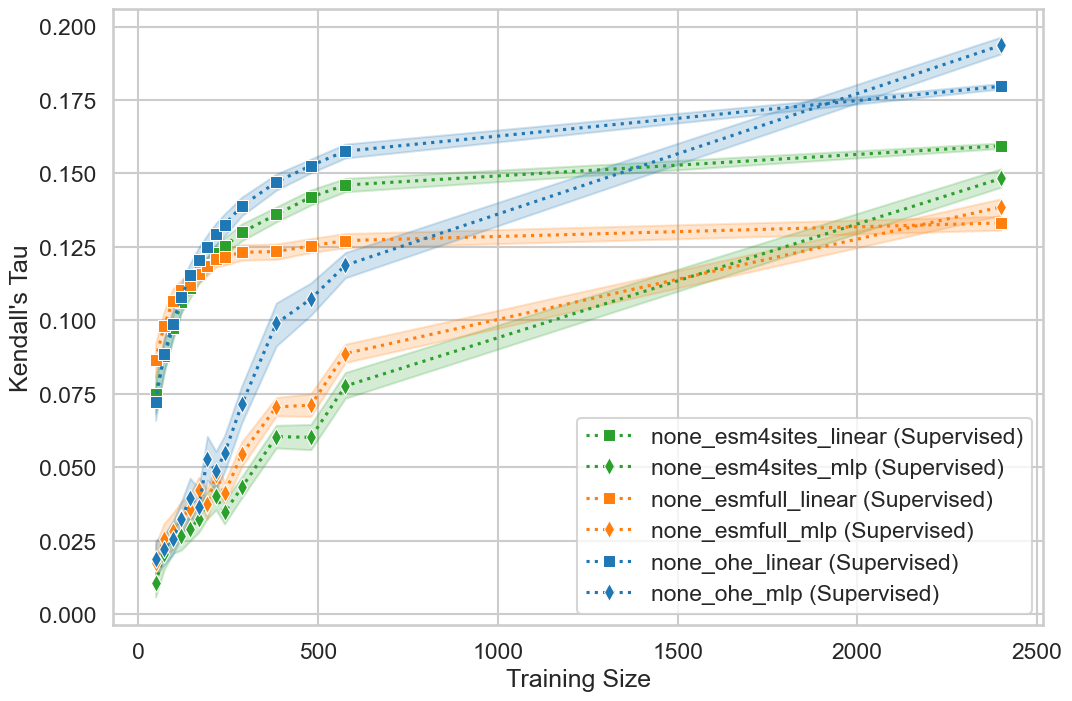

In [70]:
# now compare linear to nonlinear models
metric = 'kendall_tau'

fig, ax = plt.subplots(figsize=(12, 8))

for model, df in supervised_df.groupby('Model'):
    df_ = df[df['Metric'] == metric]
    color, linestyle, marker = color_map[model.split('_')[1]], linestyle_map[model.split('_')[0]], marker_map[model.split('_')[2]]
    if model.split('_')[0] != 'none':
        continue
    label = model
    if model.split('_')[0] == 'none':
        label += ' (Supervised)'
    else:
        label += ' (Augmented)'
    sns.lineplot(x='Training Size', y='Score', data=df_, ax=ax,
                    label=label, color=color, linestyle=linestyle, marker=marker)

ax.set_xlabel('Training Size')
ax.set_ylabel("Kendall's Tau")
plt.legend()
plt.savefig('nonlinear_vs_linear_kendall.png', bbox_inches='tight', dpi=300)

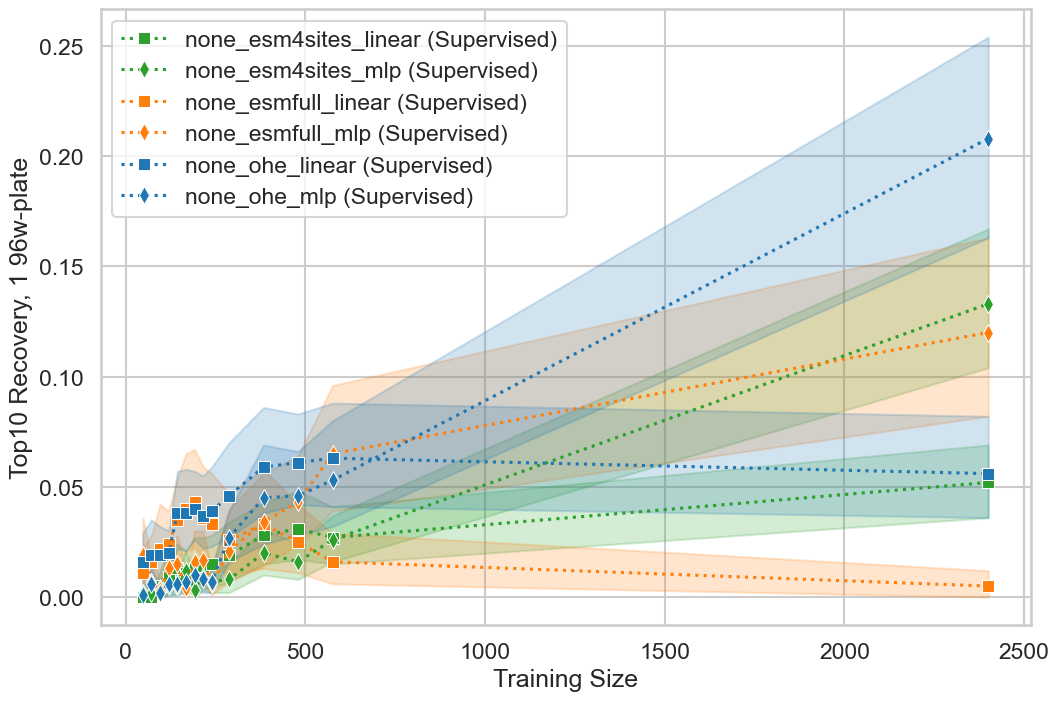

In [71]:
# now compare linear to nonlinear models
metric = 'top10_in_plate'

fig, ax = plt.subplots(figsize=(12, 8))

for model, df in supervised_df.groupby('Model'):
    df_ = df[df['Metric'] == metric]
    color, linestyle, marker = color_map[model.split('_')[1]], linestyle_map[model.split('_')[0]], marker_map[model.split('_')[2]]
    if model.split('_')[0] != 'none':
        continue
    label = model
    if model.split('_')[0] == 'none':
        label += ' (Supervised)'
    else:
        label += ' (Augmented)'
    sns.lineplot(x='Training Size', y='Score', data=df_, ax=ax,
                    label=label, color=color, linestyle=linestyle, marker=marker)

ax.set_xlabel('Training Size')
ax.set_ylabel("Top10 Recovery, 1 96w-plate")
plt.legend()
plt.savefig('nonlinear_vs_linear_top10.png', bbox_inches='tight', dpi=300)